## Wykład 5
---
+ Wykonanie współbieżne
+ Obliczenia równoległe
+ Operacje równoległe wysokopoziomowe
+ Dynamiczny scheduling
+ Tablice współdzielone
+ Menadżer klastra
+ Tablice rozproszone
+ zbiór Julii


## Wsparcie dla wykonania współbieżnego

Zadania (tasks)  wykonuja zdefiniowaną procedurę. 

Jest to inny rodzaj przepływu kontroli - od trybu wykonania zwykłych instrikcji różnia sie tym, ze mogą zostać wiele razy  przerwane i wznowione = nie muszą wykonać się po kolei.

Za szeregowanie tasków (który kiedy się wykona itd.) odpowiedzialny jest Scheduler

Istnieją dwa rodzaje podejścia do przełączania tasków:

- <b>preemptive</b> - z wywłaszczeniem - scheduler sam decyduje kiedy przełączyć zadanie aby uzyskać płynną wielozadaniowość.
    - plusy: często bardziej wydajne, 
    - minusy: może prowadzić do wyścigów. np. wątki w Javie. 

- <b>cooperative</b>  - taski są przełączane tylko w dobrze zdefiniowanych punktach synchronizacyjnych. 
    - Minusy: jeśli taski nie wykorzystują tej możliwości właściwie, nie kooperują ze sobą, aby efektywnie wykorzystać procesor,  system może działać wolno. 
    - Plusy: nie trzeba martwić się o sytuacje wyścigu (łatwiejsza implementacja). 
    - Jest to rozwiązanie, które wybrano w Julii. 

inne nazwy dla tasków występujących w Julii: symmetric coroutines, lightweight threads, cooperative multitasking,  one-shot continuations.

Te możliwości nie oznaczają  automatycznie wykonania tasków na różnych węzłach / procesorach równolegle. 

Taski mogą przeplatać się w obrębie jednego węzła - mówimy wtedy o wykonaniu współbieżnym.

Jeśli używamy wielu węzłów/procesorów - wykonanie jest nie tylko współbieżne, ale i równoległe.


Kiedy stosuje się wielozadaniowość?

- Przy rozwiązywaniu pewnych problemów sposób z wywołaniem kolejnych  funkcji nie jest oczywisty.

- Przykładem jest problem producenta i konsumenta, w którym jedna złożona procedura generuje wiele wartości przez jakiś czas  i kolejna procedura ich używa. 

- Rozwiązanie polegające na tym,że konsument wywoła funkcję producenta nie jest wygodne, ponieważ producent może mieć więcej wartości do wygenerowania i trzeba wtedy czekać na zakończenie ich generacji, tymczasem konsument może  chcieć działać już na tych początkowych wartościach.

- Dlatego lepiej użyc mechanizmu przeplatającego - w tym przykładzie funkcja produce() wymusza przełączenie się na task realizujący consume(). Kolejne wywołania consume() powodują przełączanie się na task producenta. 

In [1]:
function producer()
         produce("start")
         for n=1:4
           produce(2n)
         end
         produce("stop")
end;

In [2]:
p = Task(producer)

Task (runnable) @0x00007efc4788a980

In [3]:
consume(p)

"start"

In [4]:
consume(p)

2

In [5]:
consume(p)

4

In [6]:
consume(p)

6

In [7]:
consume(p)

8

In [8]:
consume(p)

"stop"

In [9]:
consume(p)

()

In [10]:
# można też użyć pętli do konsumowania kolejnych produkowanych wartości.
for x in Task(producer)
         println(x)
       end

start
2
4
6
8
stop


 konstruktor Task() przyjmuje funkcję bezargumentową, 
 

In [11]:
# konstruktor Task() przyjmuje funkcję bezargumentową,  
# można to obejść używająć funkcji anonimowej

function param_producer(name)
    produce(name* " start")
         for n=1:4
           produce(2n)
         end
    produce("stop")
    
end

p1 = Task(() -> param_producer("Zielony Goblin"))






Task (runnable) @0x00007efc47917d00

In [12]:
istaskstarted(p1)

false

In [13]:
consume(p1)

"Zielony Goblin start"

In [14]:
istaskstarted(p1)

true

In [15]:
# albo użyć makra:
p3 = @task param_producer("SpiderMan")
consume(p3)

"SpiderMan start"

In [16]:
istaskstarted(p3)

true

Więcej o możliwych funkcjach wykonywanych na taskach (uzyskiwanie informacji, który task jest uruchomiony, możliwości niskopoziomowego przełączania się itd.):

https://docs.julialang.org/en/stable/stdlib/parallel/#tasks

In [17]:
# zmienna typu Task zawiera wiele informacji
fieldnames(p3)

13-element Array{Symbol,1}:
 :parent    
 :storage   
 :state     
 :consumers 
 :donenotify
 :result    
 :exception 
 :backtrace 
 :code      
 :ctx       
 :bufsz     
 :stkbuf    
 :ssize     

In [18]:
# Stan tasku:

p3.state

:runnable

Inne stany:
https://docs.julialang.org/en/stable/manual/control-flow/#task-states

Makro @async opakowuje wyrażenie jako Task i dodaje do kolejki  schedulara na <b> lokalnej</b> maszynie.

In [19]:
println("--->")

function producent()
    println("+ producent zaczyna")
    produce("produkt 1 ")
    produce("produkt 2")
    println("+ producent kończy")
end

function konsument(p::Task)
    println("* konsument zaczyna")
    for s in p
        println("odebrałem ", s)
    end
    println("* konsument kończy")
end

@sync begin
    a = @async producent()
    @async konsument(a)
end

println("<---")

--->
+ producent zaczyna
* konsument zaczyna
odebrałem produkt 1 
odebrałem produkt 2
+ producent kończy
* konsument kończy
<---


In [20]:
# sleep() powoduje zablokowanie tasku, scheduler przełącza na inny, aktywny task. 
for i in 1:3
    @async begin
        print("Zadanie $i\n ")
        sleep(rand()*0.1)
        print(" ($i) etap 1\n ")
        sleep(rand()*0.1)
        print(" ($i) etap 2\n")
        sleep(rand()*0.1)
    end
end
print("Główne zadanie\n")

Główne zadanie
Zadanie 1
 Zadanie 2
 Zadanie 3
  (2) etap 1
  (3) etap 1
  (1) etap 1
  (1) etap 2
 (2) etap 2
 (3) etap 2


In [21]:
# jeden ze sposobów wymuszenia kolejności - użycie ReentrantLock do synchronizacji
l = ReentrantLock()
@sync for i in 1:3
    @async begin
        lock(l)
        try
            print("Zadanie $i\n")
            sleep(rand()*0.2)
            print("($i) etap 1 \n")
            sleep(rand()*0.2)
            print("($i) etap 2\n")
        finally
            unlock(l)
        end
    end
end
print("Główne zadanie\n")

Zadanie 1
(1) etap 1 
(1) etap 2
Zadanie 2
(2) etap 1 
(2) etap 2
Zadanie 3
(3) etap 1 
(3) etap 2
Główne zadanie


## Wykonywanie równoległe
- Architektura master - worker.
- master - proces, z którego sterujemy wykonaniem programu
- master zleca wykonanie danej funkcji na innym procesie i ściąga wynik

In [23]:
# Uruchomienie procesów workerów (zwykle podajemy tyle, ile węzłów chcemy wykorzystać)
# jesli uruchamiamy konsole julii to można też użyć opcji 
# julia -p ilosc_workerów
# do usuwania workerów służy  rmprocs() - tylko dla procesu master !
if nprocs() == 1
    addprocs(4)
end
# wszystkie procesy
nprocs() |> println
# procesy workerów
# tablica identyfikatorów
workers() |> println
# ilość
nworkers()|> println

5
[2,3,4,5]
4


In [23]:
# każdy proces ( w tym główny) ma swój identyfikator
myid()

1

In [24]:
# uruchom funkcje na wybranym workerze, zwraca future
# future = "pudełko" na wynik, które wypełni się, jak wynik będzie gotowy
# argumenty:
# 1. funkcja jaka się ma wykonać
# 2. identyfikator workera, 
# 3. parametry funkcji
ref = remotecall(myid,workers()[1])

Future(2,1,6,Nullable{Any}())

In [25]:
# czekamy na wynik i wypełniamy pudełko
_id = fetch(ref)
println(_id)

2


In [26]:
tic()
ref = remotecall(x->(sleep(x);10x), workers()[1], 2)
toc()
tic()
fetch(ref) |> println
toc();

elapsed time: 0.346871615 seconds
20
elapsed time: 2.427033492 seconds


In [29]:
# przekazywanie RemoteRef między procesami
# makro @spawnat oblicza na workerze, którego identyfikator jest podany w pierwszym argumencie
# wyrażenie podane w  drugim argumencie 
# makro - wygodniejsze w użyciu niż funkcja


r = remotecall(()->rand(2,2),2)
s = @spawnat 3 fetch(r)+1
fetch(s)

2×2 Array{Float64,2}:
 1.83078  1.75558
 1.55924  1.25624

In [30]:
# makro @spawn wybiera zdalny proces. Druga linijka wykona się na tym samym procesie co pierwsza, 
# aby nie trzeba było przesyłać danych
# można definiować własne makra typu @spawn
# raz ściągnięty wynik future jest przechowywany lokalnie (cache), wartość przechowywana zdalnie jest kasowana.
r = @spawn rand(2,2)
s = @spawn 1 .+ fetch(r)
fetch(s)

2×2 Array{Float64,2}:
 1.89646  1.2827 
 1.36438  1.16835

In [31]:
# Jeśli operujemy na dużych danych warto zadbać, aby ich niepotrzebnie nie przesyłać.

# tutaj dane (wygenerowana tablica) są przesyłane z procesu 1 do procesu zdalnego
A = rand(1000,1000)
Bref = @spawn A^2
fetch(Bref)

# tutaj tablica generuje się już "na miejscu"
Bref = @spawn rand(1000,1000)^2
fetch(Bref);

In [32]:
# Co, jeśli zdefiniujemy własne funkcje, czy będą widoczne na pozostałych procesach?
function rand2(dims...)
    return 2*rand(dims...)
end

rand2 (generic function with 1 method)

In [33]:
rand2(2,2)

2×2 Array{Float64,2}:
 1.73838  0.0214448
 1.33918  1.82099  

In [34]:
#Proces nr 1 to master - wie o zdefiniowanej funkcji
r1 = @spawnat 1 rand2(2,2)
fetch(r1)

2×2 Array{Float64,2}:
 1.643    0.424488
 1.72305  1.80976 

In [13]:
# Proces nr 2 nie wie nic o nowo zdefiniowanej funkcji
r2 = @spawnat 2 rand2(2,2)
fetch(r2)

LoadError: On worker 2:
UndefVarError: #rand2 not defined
 in deserialize_datatype at ./serialize.jl:823
 in handle_deserialize at ./serialize.jl:571
 in collect at ./array.jl:307
 in deserialize at ./serialize.jl:588
 in handle_deserialize at ./serialize.jl:581
 in deserialize at ./serialize.jl:541
 in deserialize_datatype at ./serialize.jl:829
 in handle_deserialize at ./serialize.jl:571
 in deserialize_msg at ./multi.jl:120
 in message_handler_loop at ./multi.jl:1317
 in process_tcp_streams at ./multi.jl:1276
 in #618 at ./event.jl:68

In [35]:
# makro everywhere uruchamia kod na wszystkich procesach, 
# może być użyte do zdefioniowania funkcji wszędzie
@everywhere function idtable(dims...)
    return myid()*ones(dims...)
end

In [36]:
r1 = @spawnat 3 idtable(2,2)
fetch(r1)

2×2 Array{Float64,2}:
 3.0  3.0
 3.0  3.0

In [37]:
# definiujemy wszędzie A=1, a potem lokalnie zmieniamy A na 10000
@everywhere A=1
A=10000

10000

In [17]:
A

10000

In [38]:
# ta funkcja to efektywne połączenie remote_call() i fetch() w jednym.
remotecall_fetch(workers()[2],()->A)

1

In [39]:
@everywhere B=[(i,j) for i=1:5, j=1:5]
B[1,1]=(1000,1000)

(1000,1000)

In [40]:
B

5×5 Array{Tuple{Int64,Int64},2}:
 (1000,1000)  (1,2)  (1,3)  (1,4)  (1,5)
 (2,1)        (2,2)  (2,3)  (2,4)  (2,5)
 (3,1)        (3,2)  (3,3)  (3,4)  (3,5)
 (4,1)        (4,2)  (4,3)  (4,4)  (4,5)
 (5,1)        (5,2)  (5,3)  (5,4)  (5,5)

In [41]:
# wykonaj funkcję identity() na macierzy B, 
# tutaj B jest brana z otoczenia funcji remotecall_fetch, czyli procesu 1
remotecall_fetch(workers()[2],identity,B)

5×5 Array{Tuple{Int64,Int64},2}:
 (1000,1000)  (1,2)  (1,3)  (1,4)  (1,5)
 (2,1)        (2,2)  (2,3)  (2,4)  (2,5)
 (3,1)        (3,2)  (3,3)  (3,4)  (3,5)
 (4,1)        (4,2)  (4,3)  (4,4)  (4,5)
 (5,1)        (5,2)  (5,3)  (5,4)  (5,5)

In [42]:
# tutaj na workerze 2 wykonuje się funkcja nie biorąca żadnych argumentów i zwracająca tamtejsze B
remotecall_fetch(workers()[2],()->B)

5×5 Array{Tuple{Int64,Int64},2}:
 (1,1)  (1,2)  (1,3)  (1,4)  (1,5)
 (2,1)  (2,2)  (2,3)  (2,4)  (2,5)
 (3,1)  (3,2)  (3,3)  (3,4)  (3,5)
 (4,1)  (4,2)  (4,3)  (4,4)  (4,5)
 (5,1)  (5,2)  (5,3)  (5,4)  (5,5)

### Operacje równoległe wysokopoziomowe

In [43]:
# każda operacja I^100 wykonywana jest równolegle (map) - master nie bierze udziału w obliczeniach
# wyniki wszystkich operacji równoległych są sumowane (reduce) - wykonywana w procesie wywołującym 

@parallel (+) for i=1:1000 
        BigInt(i)^100

end

10409322085141927639670203491499689537738780837791755480023910122413796284563817273031715389609548981241768473547819207141766480065813697534743324177871972318309449519400285796191029154173386427179568557187635957090705352571527670654111047109630289487169691389452699579236618703725748994463357307313300

In [44]:
# tutaj każdy proces ma swoją kopię tablicy a, więć kod nie zadziała dobrze
# @sync - czekamy na zakończenie się wszystkich obliczeń.
# master nie bierze udziału w obliczeniach.
a = zeros(10)
@sync @parallel for i=1:10
  a[i] = i
end
a


10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [45]:
# tutaj tablica jest współdzielona (SharedArray), każdy proces modyfikuje jej kawałek.

a1=SharedArray(Float64,10)
@sync @parallel for i=1:10
  a1[i] = i
end
a1



10-element SharedArray{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [8]:
a2=SharedArray(Int8,10)
@sync @parallel for i=1:10
  a2[i] = myid()
end
a2

10-element SharedArray{Int8,1}:
 2
 2
 2
 3
 3
 3
 4
 4
 5
 5

In [46]:
# pmap - działa podobnie jak @parallel for bez redukcji, ale jest wydajniejsza dla dłużej trwających operacji.

lst = collect(1:10)

pmap(x->myid(),lst)


10-element Array{Any,1}:
 2
 4
 5
 3
 3
 2
 3
 2
 3
 2

### Dynamiczny scheduling w funkcji pmap

INFO: Recompiling stale cache file /home/user/.julia/lib/v0.5/Images.ji for module Images.
INFO: Recompiling stale cache file /home/user/.julia/lib/v0.5/ImageMagick.ji for module ImageMagick.


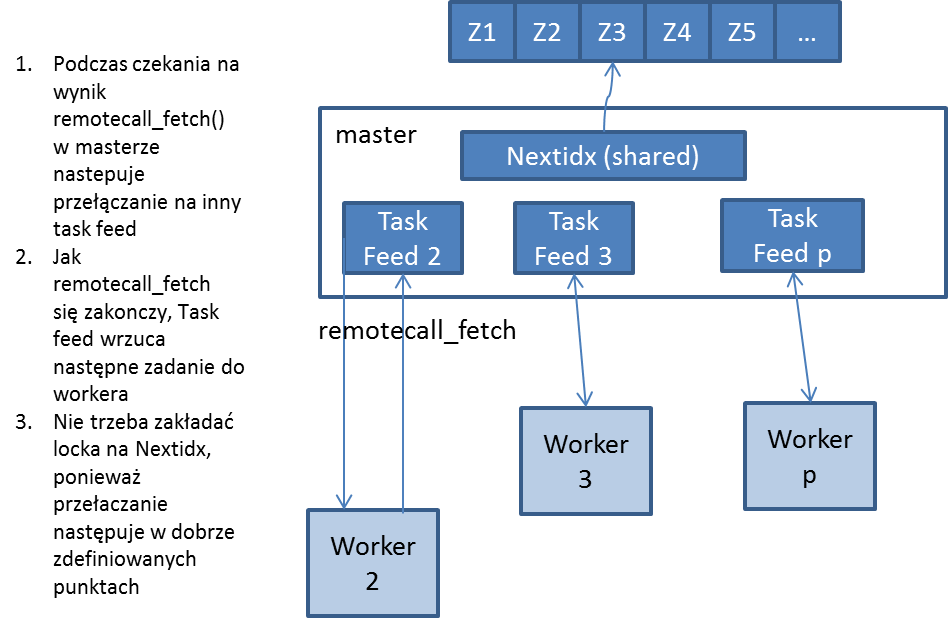

In [18]:
using Images
using FileIO
img = load("workerzy.png")

In [17]:
function pmap2(f, lst)
    np = nprocs()  # ile procesów ?
    n = length(lst)
    results = Vector{Any}(n)
    i = 1
    # indeks nastepnego zadania do zrobienia
    nextidx() = (idx=i; i+=1; idx)
    @sync begin
        for p=1:np
            if p != myid() || np == 1
                # tworzenie lokalnych tasków feed
                # żaden nie zacznie działać dopóki wszystkie nie zostaną utworzone i task główny nie wyjdzie 
                # z pętli @sync, gdzie będzie czekał na ich zakończenie
                @async begin
                    while true
                        idx = nextidx()
                        if idx > n
                            break
                        end
                        results[idx] = remotecall_fetch(f, p, lst[idx])
                    end
                end
            end
        end
    end
    results
end
#przykładowe użycie
M = Matrix{Float64}[rand(800,800), rand(600,600), rand(800,800), rand(600,600)]
pmap2(svd, M);

## Tablice współdzielone
- Pozwalają na współdzielenie jednej tablicy pomiędzy wieloma procesami wykonywanymi na jednej maszynie ze wspólną pamięcią.
- Każdy z procesów ma dostęp do każdej części tablicy.

In [47]:
# utworzenie tablicy współdzielonej
S=SharedArray(Float64, (10,2))

10×2 SharedArray{Float64,2}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [48]:
# worker 2 ustawia w tablicy S wartosc 2 w miejscu (1,1) 
remotecall_fetch(2,setindex!,S,2,1,1)

10×2 Array{Float64,2}:
 2.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [49]:
# efekt widac w masterze
S

10×2 SharedArray{Float64,2}:
 2.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [51]:
#Wector procesów uzywających  SharedArray
procs(S)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [53]:
# zwraca dane w SharedArray jako Array
sdata(S)

10x2 Array{Float64,2}:
 2.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [81]:
# dygresja: wypelnianie tablicy co 4 elementy (idziemy po kolumnach)
A=zeros(10,10)
A[1:4:length(A)]=1
A

10×10 Array{Float64,2}:
 1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [85]:
# kazdy worker współdzielący tablice ma swój indeks (numerowane od 1..ilość workerów) 
idx = fetch(@spawnat 3 indexpids(S))
idx |> println
workers()[idx] |> println

2
3


In [42]:
# wypeniamy współdzieloną tablicę - każdy worker cyklicznie wpisuje swój 
#identyfikator co tyle pól, ile jest workerów.

S = SharedArray(Int, (3,4), init = S -> S[indexpids(S):length(procs(S)):length(S)] = myid())

3×4 SharedArray{Int64,2}:
 2  5  4  3
 3  2  5  4
 4  3  2  5

In [43]:
# każdy worker wypełnia  całą tablicę swoim identyfikatorem
# wynik jest niedeterministyczny - zależy od kolejności w jakiej workerzy wypełniają tę tablicę 
@sync begin
    for p in procs(S)
        @async begin
            remotecall_wait(fill!, p, S, p)
        end
    end
end
S

3×4 SharedArray{Int64,2}:
 3  2  2  2
 3  2  2  2
 3  2  2  2

In [15]:
# pomocniczo: tworzy linspace 5-ciu równoodległych elementów od 0 do 10
linspace(0,10,5)

5-element LinSpace{Float64}:
 0.0,2.5,5.0,7.5,10.0

In [19]:
# pomocniczo: zaokrąglanie
round(Int, 4.51)

5

In [14]:
 # pomocniczo: tworzy linspace 5-ciu równoodległych elementów od 0 do 10 i zaokrągla
[round(Int, s) for s in linspace(0,10,5)]

5-element Array{Int64,1}:
  0
  2
  5
  8
 10

In [9]:
# żeby mieć wpływ na to, który worker działa na którym elemencie tablicy 
# możemy stworzyć ręczny podział tablicy
# każdy worker wylicza, który kawałek tablicy dostanie
@everywhere function myrange(q::SharedArray)
    idx = indexpids(q)
    if idx == 0
        # master nie dostaje kawałka 
        return 1:0, 1:0
    end
    # na ile mamy podzielić?
    nchunks = length(procs(q))
    
    # wyliczamy granice podziałów
    splits = [round(Int, s) for s in linspace(0,size(q,2),nchunks+1)]
    # zwracamy granice podziałów w odpowiednim formacie
    1:size(q,1), splits[idx]+1:splits[idx+1]
end

# kernel obliczeniowy 
@everywhere function advection_chunk!(q, u, irange, jrange, trange)
    @show (irange, jrange, trange)  # wyświetlanie
    for t in trange, j in jrange, i in irange
        q[i,j,t+1] = q[i,j,t] +  u[i,j,t]
    end
    q
end

#  definiujemy obliczenie kernela z wyliczonym podziałem przez funkcje myrange()
@everywhere advection_shared_chunk!(q, u) = advection_chunk!(q, u, myrange(q)..., 1:size(q,3)-1)


In [ ]:
# wersja 1: wywołanie funkcji wg wyliczonego podziału na wielu workerach.
function advection_shared!(q, u)
    @sync begin
        for p in procs(q)
            @async remotecall_wait(advection_shared_chunk!, p, q, u)
        end
    end
    q
end


In [10]:
# wersja 2: sekwencyjne obliczanie
advection_serial!(q, u) = advection_chunk!(q, u, 1:size(q,1), 1:size(q,2), 1:size(q,3)-1)


advection_serial! (generic function with 1 method)

In [20]:
#  wersja 3: nie korzysta z ręcznego podziału, tylko z makra @parallel działającego drobnoziarniście 
# wzdłuż drugiej współrzędnej
function advection_parallel!(q, u)
    for t = 1:size(q,3)-1
        @sync @parallel for j = 1:size(q,2)
            for i = 1:size(q,1)
                q[i,j,t+1]= q[i,j,t] + u[i,j,t]
            end
        end
    end
    q
end


advection_parallel! (generic function with 1 method)

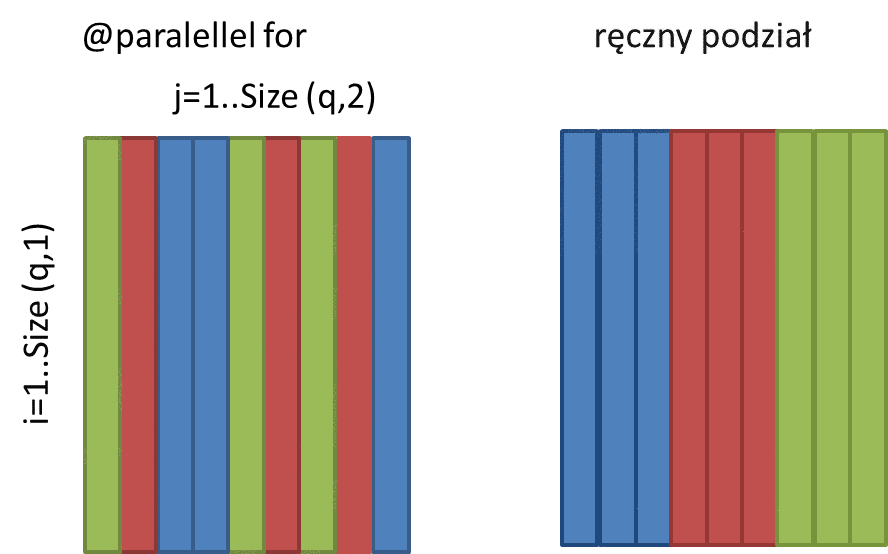

In [10]:
using Images
using FileIO
img = load("shared_arrays.png")

In [29]:
q = SharedArray(Float64, (200,200,200))
u = SharedArray(Float64, (200,200,200))

# Uruchamiamy do celów kompilacji
advection_serial!(q, u)
advection_parallel!(q, u)
advection_shared!(q,u);



(irange,jrange,trange) = (1:200,1:200,1:199)
	From worker 2:	(irange,jrange,trange) = (1:200,1:50,1:199)
	From worker 3:	(irange,jrange,trange) = (1:200,51:100,1:199)
	From worker 5:	(irange,jrange,trange) = (1:200,151:200,1:199)
	From worker 4:	(irange,jrange,trange) = (1:200,101:150,1:199)


In [30]:
@time advection_serial!(q, u);

(irange,jrange,trange) = (1:200,1:200,1:199)
  0.056974 seconds (169 allocations: 8.828 KB)


In [31]:
@time advection_parallel!(q, u);

 46.443486 seconds (318.34 k allocations: 9.752 MB)


In [28]:
@time advection_shared!(q,u);

	From worker 2:	(irange,jrange,trange) = (1:100,1:25,1:99)
	From worker 4:	(irange,jrange,trange) = (1:100,51:75,1:99)
	From worker 5:	(irange,jrange,trange) = (1:100,76:100,1:99)
	From worker 3:	(irange,jrange,trange) = (1:100,26:50,1:99)
  0.015676 seconds (1.12 k allocations: 69.891 KB)


### Menadżer klastra

Uruchomienie, zarządzanie i łączenie procesów Julii w logiczny klaster odbywa się za pośrednictwem menedżerów klastrów. ClusterManager odpowiedzialny jest za

- uruchamianie procesów roboczych (workerów)
- zarządzanie zdarzeniami w trakcie życia workerów
- transport danych (opcjonalnie)

Klaster Julii ma następujące cechy:

-   proces nadrzędny (master) ma identyfikator równy 1.
-   tylko proces nadrzędny może dodawać lub usuwać workerów.
-   wszystkie procesy mogą się komunikować ze sobą nawzajem.

Połączenia między workerami (przy użyciu wbudowanego transportu TCP / IP) są ustalane w następujący sposób:

 - Addprocs() jest wywoływany w procesie nadrzędnym 
 - Addprocs() wywołuje odpowiednią metodę launch(), która uruchamia wymaganą liczbę procesów roboczych na odpowiednich maszynach
 - Każdy worker zaczyna słuchać na wolnym porcie i wypisuje informacje o hostach i portach na STDOUT
 - Menedżer klastrów przechwytuje STDOUT workerów i udostępnia je do procesu nadrzędnego
 - Master  nawiązuje połączenia TCP / IP z każdym workerem
 - Każdy worker jest również informowany o innych workerach
 - Każdy worker łączy się ze wszystkimi workerami, których identyfikator jest mniejszy niż identyfikator danego workera
    W ten sposób powstaje sieć powiązań, w której każdy worker jest bezpośrednio związany z każdym innym workerem



Julia oferuje dwóch wbudowanych menedżerów klastrów:

    - LocalManager  - do uruchamiania dodatkowych workerów na tym samym hoście, wykorzystując wiele rdzeni (Użycie addprocs() lub addprocs(np :: Integer))
    - SSHManager -do uruchamiania dodatkowych workerów na zdalnych hotach dostępnych przez SSH,(użycie addprocs (hostnames :: Array) -  lista nazw hostów)



### Sieć, TCP

In [1]:
# prosty serwer TCP 
@async begin
            server = listen(2000)
             while true
               sock = accept(server)
               println("Cześć tutaj serwer")
             end
       end

Task (runnable) @0x00007ff911b26e60

In [2]:
client1=connect(2000)

Cześć tutaj serwer


TCPSocket(open, 0 bytes waiting)

In [3]:
close(client1)

In [4]:
# Przełączenie się między obsługą wielu połączeń
@async begin
         server = listen(2001)
         while true
           sock = accept(server)
           @async while isopen(sock)
             write(sock,readline(sock))
           end
         end
       end

Task (runnable) @0x00007ff912c80eb0

In [5]:
clientside = connect("localhost",2001)

TCPSocket(open, 0 bytes waiting)

In [6]:
# task zczytujący odpowiedzi z serwera, jeśli ich nie ma, zostaje wywłaszczony
@async while true
          write(STDOUT,readline(clientside))
       end

Task (runnable) @0x00007ff912c909d0

In [7]:
println(clientside,"Hello World from the Echo Server3")

Hello World from the Echo Server3


In [9]:
close(clientside)

In [10]:
clientside

TCPSocket(closed, 0 bytes waiting)

## Tablice rozproszone
- Każdy proces ma dostęp do swojej części tablicy.
- Pozwalają na wykorzystanie pamięci wielu węzłów.
- przydatne w środowisku rozproszonym, gdzie węzły nie mają pamięci wspólnej
```julia
Pkg.add("DistributedArrays")
```

In [34]:
@everywhere using DistributedArrays
DA = @DArray [(i,j,k) for i = 1:5, j = 1:5, k=1:5]


5×5×5 DistributedArrays.DArray{Tuple{Int64,Int64,Int64},3,Array{Tuple{Int64,Int64,Int64},3}}:
[:, :, 1] =
 (1,1,1)  (1,2,1)  (1,3,1)  (1,4,1)  (1,5,1)
 (2,1,1)  (2,2,1)  (2,3,1)  (2,4,1)  (2,5,1)
 (3,1,1)  (3,2,1)  (3,3,1)  (3,4,1)  (3,5,1)
 (4,1,1)  (4,2,1)  (4,3,1)  (4,4,1)  (4,5,1)
 (5,1,1)  (5,2,1)  (5,3,1)  (5,4,1)  (5,5,1)

[:, :, 2] =
 (1,1,2)  (1,2,2)  (1,3,2)  (1,4,2)  (1,5,2)
 (2,1,2)  (2,2,2)  (2,3,2)  (2,4,2)  (2,5,2)
 (3,1,2)  (3,2,2)  (3,3,2)  (3,4,2)  (3,5,2)
 (4,1,2)  (4,2,2)  (4,3,2)  (4,4,2)  (4,5,2)
 (5,1,2)  (5,2,2)  (5,3,2)  (5,4,2)  (5,5,2)

[:, :, 3] =
 (1,1,3)  (1,2,3)  (1,3,3)  (1,4,3)  (1,5,3)
 (2,1,3)  (2,2,3)  (2,3,3)  (2,4,3)  (2,5,3)
 (3,1,3)  (3,2,3)  (3,3,3)  (3,4,3)  (3,5,3)
 (4,1,3)  (4,2,3)  (4,3,3)  (4,4,3)  (4,5,3)
 (5,1,3)  (5,2,3)  (5,3,3)  (5,4,3)  (5,5,3)

[:, :, 4] =
 (1,1,4)  (1,2,4)  (1,3,4)  (1,4,4)  (1,5,4)
 (2,1,4)  (2,2,4)  (2,3,4)  (2,4,4)  (2,5,4)
 (3,1,4)  (3,2,4)  (3,3,4)  (3,4,4)  (3,5,4)
 (4,1,4)  (4,2,4)  (4,3,4)  (4,4,4)  (4,5,4)


In [26]:
# localindexes - jaki zakres indeksów obejmuje dany worker
refs = [remotecall(localindexes,w,DA) for w in workers()]
for r in refs
     d = fetch(r)
     println(d)
end

(1:5,1:3,1:3)
(1:5,4:5,1:3)
(1:5,1:3,4:5)
(1:5,4:5,4:5)


In [40]:
# localpart - część tablicy przyporządkowana danemu workerowi
refs = [remotecall(w,localpart,DA) for w in workers()]
for r in refs
     d = fetch(r)
     print("----------\n")
     println(d)
end

----------
Tuple{Int64,Int64,Int64}[(1,1,1) (1,2,1) (1,3,1); (2,1,1) (2,2,1) (2,3,1); (3,1,1) (3,2,1) (3,3,1); (4,1,1) (4,2,1) (4,3,1); (5,1,1) (5,2,1) (5,3,1)]

Tuple{Int64,Int64,Int64}[(1,1,2) (1,2,2) (1,3,2); (2,1,2) (2,2,2) (2,3,2); (3,1,2) (3,2,2) (3,3,2); (4,1,2) (4,2,2) (4,3,2); (5,1,2) (5,2,2) (5,3,2)]

Tuple{Int64,Int64,Int64}[(1,1,3) (1,2,3) (1,3,3); (2,1,3) (2,2,3) (2,3,3); (3,1,3) (3,2,3) (3,3,3); (4,1,3) (4,2,3) (4,3,3); (5,1,3) (5,2,3) (5,3,3)]
----------
Tuple{Int64,Int64,Int64}[(1,4,1) (1,5,1); (2,4,1) (2,5,1); (3,4,1) (3,5,1); (4,4,1) (4,5,1); (5,4,1) (5,5,1)]

Tuple{Int64,Int64,Int64}[(1,4,2) (1,5,2); (2,4,2) (2,5,2); (3,4,2) (3,5,2); (4,4,2) (4,5,2); (5,4,2) (5,5,2)]

Tuple{Int64,Int64,Int64}[(1,4,3) (1,5,3); (2,4,3) (2,5,3); (3,4,3) (3,5,3); (4,4,3) (4,5,3); (5,4,3) (5,5,3)]
----------
Tuple{Int64,Int64,Int64}[(1,1,4) (1,2,4) (1,3,4); (2,1,4) (2,2,4) (2,3,4); (3,1,4) (3,2,4) (3,3,4); (4,1,4) (4,2,4) (4,3,4); (5,1,4) (5,2,4) (5,3,4)]

Tuple{Int64,Int64,Int64}[(1,1,5)

### zbiór Julii

In [13]:
using Plots
Plots.gr()

# punkt o współrzędnych (x,y) należy do zbioru Julii o parametrze  c 
# jeśli dla liczby zespolonej z=x+i*y
# ciąg zₙ₊₁=zₙ²+c , nie dąży do nieskończoności

# dążenie do nieskończoności sprawdzamy ustawiająć maksymalną liczbę iteracji i sprawdzając
# czy kolejne wyrazy ciągu nie przekroczą zadanego progu (tutaj 2) w tej (bądź mniejszej)
# liczbie iteracji

# funkcja sprawdzająca, czy punkt z należy do zbioru Julii o parametrze c
function generate_julia(z; c=2, maxiter=200)
    for i=1:maxiter
        if abs(z) > 2
            return i-1
        end
        z = z^2 + c
    end
    maxiter
end

# obliczamy zbiór Julii na płaszczyźnie punktów od-do.

function calc_julia!(julia_set, xrange, yrange; maxiter=200, height=400, width_start=1, width_end=400)
   for x=width_start:width_end
        for y=1:height
            z = xrange[x] + 1im*yrange[y]
            julia_set[x, y] = generate_julia(z, c=-0.70176-0.3842im, maxiter=maxiter)
        end
    end
end

# główna funkcja 

function calc_julia_main(h,w)
  # ustawiamy płaszczyznę
    xmin, xmax = -2,2
   ymin, ymax = -1,1
   xrange = linspace(xmin, xmax, w)
   yrange = linspace(ymin, ymax, h)
	println(xrange[100],yrange[101])
   julia_set = Array(Int64, (w, h))
    
   # obliczamy
   @time calc_julia!(julia_set, xrange, yrange, height=h, width_end=w)
    
    # rysujemy
   pl=Plots.heatmap(xrange, yrange, julia_set)
   png("julia")
   return pl
end


calc_julia_main(2000,2000)

-1

.8019009504752377-0.8999499749874937
  2.380860 seconds (12.02 M allocations: 671.993 MB, 8.27% gc time)


<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
 
<image width="496" height="381" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAAfAAAAF9CAYAAAD7gjrgAAAgAElEQVR4nOy9eZAk2X2Y972XR1V2
Vd/n9NzHzs6xO7s7WOyBxbU4FgAlEjxAmZJohk2ZIcti2AyGHTaDjiBF26E/ZFmUGQpZoi0aETBF
EjxFkABIgCCwu1jsid3Z3bl27qOn77u6rsz3/Ed2ZldVV3VXd1d3V828b6Kjp6sqM19ldteX773f
7/cE2BqDwWAwGAwthb3bDTAYmhUh5G43wbCM1mq3m2AwNB1G4Ib7BiPc+5dGX1tzQ2C4HzACNzQN
RsCGnWKrv2vmBsDQDBiBG7YFI2PD/cxmfr+N9A2NxgjcsCZGxAZDY9js35IRv6EWRuAPKEbMBkNr
UO/fqhH9g4cR+H2IkbPB8OBRz9+9kfz9hRF4i2HkbDAYNouR/P2FEXiTYMRsMBiaATNk3zoYge8g
RtIGg+F+Ya3PMyP3ncEIvMEYSRsMhgcdI/edwQh8ExhJGwwGw+Ywcm8cRuBVMII2GAyGnWe9z14j
+HIeWIEbSRsMBkNrUetz+0EV+wMhcCNrg8FguH95UMV+XwnciNpgMBgMEfe72FtO4EbSBoPBYNgK
90sgXVML3MjaYDAYDDtJNe80q9SbQuBG1AaDwWBoVpp1KH7HBW5kbTAYDIb7gd3urW+bwI2oDQaD
wfCgsZO99YYJ3AjbYDAYDIbqVDqyEULflMCNrA0Gg8Fg2DyNGH5fV+BG1gaDwWAwbD8blXqZwI2s
DQaDwWBoHtaSum2kbTAYDAZD6xB529jbYDAYDIYWxAjcYDAYDIYWxAjcYDAYDIYWxAjcYDAYDIYW
xAjcYDAYDIYWxAjcYDAYDIYWxAjcYDAYDIYWpCmWEzUYDK3A/Xq/35xrPRsM62EEbjA8ENyv8m0E
Wz035gbAsDsYgRsMLYuRcnOw0etghG9oDEbgBkPTYIT8YLCR62xkb6iNEbjBsGMYQRs2ynq/M0bw
DzJG4AZDQzGSNuwktX7fjNgfBIzADYZNYURtaGbW+v00cr9fMAI3GKpiBG24XzFyv18wAjcYjKwN
hmWq/S0YqTcrRuCGBwwja4NhYxipNytG4Ib7GCPrZkYIa7ebUIbWwW43oYUwUm8GjMAN9wFG1M1A
swl5o2yk/Ub21TBS32mMwA0tiBH2btLqom4Ea50DI/dSjNS3EyNwQ5NjZL1b7JaoRYOvud5hYVQ7
b0bqpVReXyP0zSKEcPVuN8JgWMEIezfYDVmvL+qwTUJItF7rQ35zctxpsa86vpF6DYzQ68UI3LCL
GFnvBs0pa4iEDaG0waLPO8Fj+hEuiqu4eNwu/JBB9wR3sz8EgjXE3npSN0KvhRF6LYzADTuMkfZO
0/xD4eXtC+UdPm5Jl6TdjSOSHOY0F9QrKFUg0EUCVVh+Xbn4yqW+eSmaHnqzYoQeYebADduMEfZu
sJuBZhubw64m71DcbXYfAL4u8BsHzvJndyzS9iAQyq2gMnw++QneLYzyQeFltA5QOih57wG6rHuy
MSGWvo/dkHnlNTRCjyj9/XqwZW4JYf36bjfCcL8hAbH8ZdgphLAQQpb0YHf4+EjEhq55rZ63RAoL
pYsgJMPWSV6dXyKvFf/sSB+pwiG84gAWnfzsfs3YQhe39Aj73MfodvbzscRHuKFuoNGAQggBaMLf
y+hrYwOPYvnfRrdrJNG1Dc+TGTgNESVfD945MUPohgZgetm7QTOkc20uYryWuFeek8LClkkcK43S
AQmZwpVpjqvj3JVj+BTwKVDQWQoqgyLsfUthIbF4IfFxvl14hdn8TUp73o2cM9/tIfYI0zOvRXNc
n+3ECNywCYywd4tmkDZsJdVrLXmvPC+FFb9XWybpcQ6RVXMEuoglHDzZiYuHWhbvePFyLDKFQusg
HlIPWWuevBr1S7FZRA5G5rVpnmvUSIzADXVipL1bNIu0Ixoh72riliJKGyv/LpePJ6UbvlK4uDKF
1gF5lUETxMIGCHQRWJGZKpPaRkW+eptaGJG3Cs1znbaKEbhhDYy0d5P7R9xQXd4r0rZlkhP2x5iS
Y8wHYxR1tkxCUrjYwkUIC0ckeZzHWNRFzuvXUQRILNJWHzYu48XLscSBKr3xiHqG1itZX4xG5K1E
81yrzWAEbijBCHu3aTZpQ+PFnXT6OGJ9iCe9ft7ITgCwl26y2ue6vMGPtJ3gq4vfp6hzK3sRLknZ
Qafuw8FhTkyRJwtAAo8iBTp1H9OMEOgwzcyWSbrEEAtMI7GYLdxAoZBI9riPMKNG6JbD3M69sSz3
1bLbylB7M4kcjMzXp7muVz0YgT/wGGnvNs0o7YhGyRtWUsQALOnS7uxBCAtLuHzMepz3/HtMcptA
F5FIXJkm0AX+QceTfGX+VSThvHgCj6PqMHfFBEoEJHQCgLzIowg4rPZzU45QIMuSDufNtQ7innrC
6qBT9wMwoW+QD+bwVa4krzxiDTmvEnv11zabxMGIvD6a77pVwwj8gcWIe7dpZnFD4wLVoHakeXQO
LOGEj5XMc1vC5e96H+Xt3AQP2X28EVxCYmHj4uk2Hkv0cyW3yDOdaW4tadptwaXsInmKnE118+LS
HRxsTjuDvF8c4yd6B/m/pl6Lh9cDHQr7sHiMy/7Lseirngth1RiGB10yXG9Efj/SfNcuwgj8gcJI
uxl4kMQN1QLWVl4bSVwsp42Jkscl4WOWcHFwsXE5rg+Rtm1GihkS2HRaLgdSkmf65/nuWAe5AKby
AffUPL7wSWiXcXmPPOGceqALKFT4XQeoZYmHPfSVD2pLOHzK/TyvBK9S1Dk+JJ7jTf0ygS7wE22f
x7MhF8Dvz//Rcs+9tKxr6wyrgxF5/TTftTMCv+8x0m4Gml3aEY3I6y7bX82iMiWili6e1c1xcZZR
eZd96gALIoOnk4zKuwypvUzKCSQWUlsM6l6KBHz9F77Dj//2Z7Gx6HVtjrXDi1M5Pj/o8nvj0xQp
8k+Ge/mte6MMqH6y5HGw6RJJLosbzAYj+Hpl2FwKi6TsoE10xo+dEUc5kpa8OZelSMBNeY1MMEkx
WATAV7n4JgA2Vsa12WRuRL4RmuPaGYHflxhpNxOtIO9Gizve7zoCty2PD9kvcIG32Cce5n88kuA7
ox382dKr+CqHEBYHOEkKjzkxT0YsoAiwcbG1i4PNz/T388pkuNebegJbOyRwUSgm5Th5snG+uIPL
GU6QtMJ2zRV93uLVsEXCIS16yLKIg4uLR7vq5EsDXfzZeCjsW+IDloIZCsF8yZD6WtHsrRW1Dkbk
G2f3rp8R+H2FEXcz0Qrihq3VLl9zv+vIG8rnwYWwkMiV/O+S1LHocUu4dOtBvtS7hz+fnCaFx9mO
Nv5y8VocpNan+pkXCyyKGYoU4gC20kIvsCKq0v13iH4eEYe4GcwwJUcpUsDBZUjtY1FkGFUf0GUN
M5I/V7VQzFYqvRmRtzq7US/fCLzFMdJuNh50cUN98gbiPPBwmxWZe1Y3x8TjjMt7ABxVh/n/fvoV
PvRHPXHwmRAWz1mP81pwniIrw9gOLj+WOs1/yrxPQFTcpUBR52KZQ2WBl5X29FmHmA5ul7WrWw4z
p0b5sHiKvA74gf9NfJUr2c96AgdTEOZBYeeunxF4S2Kk3Yy0irhh80t9rrvfOsUN5fIOt12JSO9w
9xPoAof0CdpJMi5meMga4O8dXOCfXn2

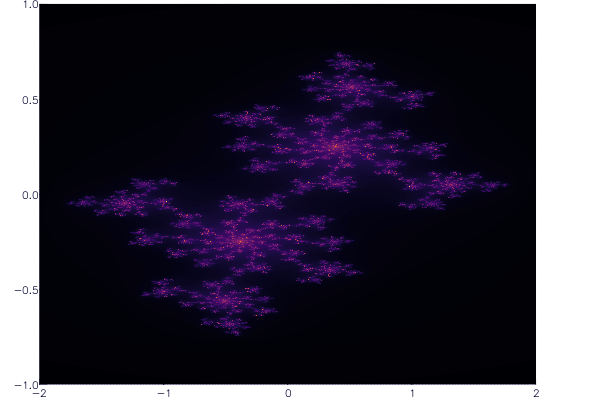

In [14]:
using Images
using FileIO
img = load("julia.png")